# Image etimator experiment

Here is an image estimator - experiment for speech emotion recognition using generated spectrograms.
I used 4 preparated datasets (*Ravee*, *Crema*, *Tess* and *Savee*) for generating spectrograms with 7 different emotions.

After that I needed to save that spectrograms as .png and distribute them to different dirs.

Then I created a covolutional neural network which recognize emotions by spectrograms.

Here we go!

## Importing libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt #plotting
import seaborn as sns
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
import os

%matplotlib inline

In [ ]:
def fill_test_dir(input_path, output_path, n_test_samples=1022):
    """Split dataset on train/test parts"""
    for emotion in os.listdir(input_path):
        inp = os.path.join(input_path, emotion)
        out = os.path.join(output_path, emotion)
        if len(os.listdir(out)) == 0:
            for ind, img in enumerate(os.listdir(inp)):
                src_path_to_img = os.path.join(inp, img)
                dst_path_to_img = os.path.join(out, img)
                os.replace(src_path_to_img, dst_path_to_img)
                if ind > n_test_samples:
                    break
    print("Test_spectrograms has been filled.")

In [ ]:
# Variables on Colab

root_ds = "/drive/MyDrive/Datasets/speech_emotion_recognition/"

path = "/content/drive/MyDrive/Datasets/speech_emotion_recognition/spectrograms"
output_path = "/content/drive/MyDrive/Datasets/speech_emotion_recognition/test_spectrograms"

fill_test_dir(path, output_path)

Test_spectrograms has been filled.


## Create generators

### Let's create some *ImageDataGenerators* for our model:

In [ ]:
# We will also use *rescale* (normalization) right in generators for simplifying
trdata = ImageDataGenerator(rescale=1./255, validation_split=0.2,)
testdata = ImageDataGenerator(rescale=1./255)

train_data = trdata.flow_from_directory(directory=path,
                                        target_size=(256,256),
                                        seed=42, 
                                        subset="training",
                                        batch_size=64)
val_data = trdata.flow_from_directory(directory=path,
                                      target_size=(256,256),
                                      seed=42,
                                      subset="validation",
                                      batch_size=64)
test_data = testdata.flow_from_directory(directory=output_path,
                                         target_size=(256,256),
                                         batch_size=64)

Found 23529 images belonging to 7 classes.
Found 5881 images belonging to 7 classes.
Found 7076 images belonging to 7 classes.


## Training model

In [ ]:
batch_size = 32
EPOCHS = 30


In [ ]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu", input_shape=(256, 256, 3)))
model.add((BatchNormalization()))
model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu"))
model.add((BatchNormalization()))
model.add(MaxPool2D(pool_size=(2,2), padding="same"))

model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu"))
model.add((BatchNormalization()))
model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu"))
model.add((BatchNormalization()))
model.add(MaxPool2D(pool_size=(2,2), padding="same"))

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu"))
model.add((BatchNormalization()))
model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu"))
model.add((BatchNormalization()))
model.add(MaxPool2D(pool_size=(2,2), padding="same"))


model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu"))
model.add((BatchNormalization()))
model.add(MaxPool2D(pool_size=(2,2), padding="same"))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add((BatchNormalization()))
model.add(Dense(7, activation="softmax"))

In [ ]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 256, 256, 64)      4864      
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)      102464    
_________________________________________________________________
batch_normalization_9 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      102464    
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 64)     

In [ ]:
early = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, factor=0.5)

In [ ]:
history = model.fit(train_data, validation_data=val_data,
              batch_size=batch_size,
              epochs=EPOCHS,
              callbacks=[early, reduce_lr])

In [ ]:
model.save('/content/drive/MyDrive/Datasets/speech_emotion_recognition/saved_model/my_model_with_BN.h5') 

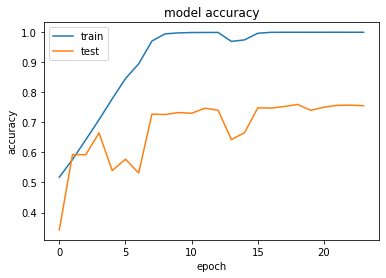

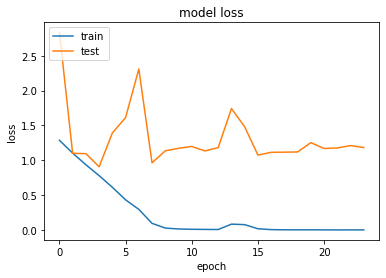

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = load_model('/content/drive/MyDrive/Datasets/speech_emotion_recognition/saved_model/my_model.h5')

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_data, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
111/111 [==============================] - 2866s 26s/step - loss: 1.0354 - accuracy: 0.8168
test loss, test acc: [1.035442590713501, 0.8168456554412842]
